# Near Real-Time Flu Estimation via Wikipedia

## Introduction



In the following notebook we are going to reproduce for Italy McIver paper et al. "Wikipedia usage estimates Prevalence of Influenza-like illness in theUnited States in near real time". In this paper we show a method of estimating, in near-real time, the level of influenza-like illness (ILI) in Italy by monitoring the rate of particular Wikipedia article views on a daily basis. We calculated on a weekly base the number of times certain influenza- or health-related Wikipedia articles were accessed and compared these data to one of the Italian health protection agency program called "Influnet".

The Notebook in the those three following sections:

* **Comparing Influnet and Wikipedia's Influenza click throught rate**
    * Retrivial and cleaning of the wikipedia pages:
        * Using 3rd party toolkit wikishark
        * Downloading the raw data from https://dumps.wikimedia.org/ (bonus point)
    * Plot the two scaled curves on the same figure
    * Compute Correlation
* **Comparing Influnet data with other Wikipedia's related pages:**
    * Retrivial and Cleaning
    * Plotting and correlation analysis among each other
* **Estimate Flu outbreaks:**
    * Lasso
    * Jesus
    
In the whole notebook we will make use of the following convetions:

## 1 - Comparison between Influnet and  Wikipedia Influenza 

In this section we are going to define the auxiliary functions that I defined in order to perform in order to perform data analysis in a more efficient way: 

In [1]:
import pandas as pd
import numpy as np
from os import listdir
import matplotlib.pyplot as plt
from scipy.stats import pearsonr 
import seaborn as sb
import datetime as dt
import scipy
import os
import sys
import operator
from sklearn.linear_model import LassoCV, ElasticNetCV
from sklearn.preprocessing import Imputer
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from math import sqrt

plt.style.use('seaborn-dark-palette')

wikiFolder = "/home/aalto/PycharmProjects/digitalepidemiology/data/clean/"
influnetData = "/home/aalto/Desktop/digital epidemiology/DE/hw2/influnet/sorted.csv"


Those functions import the influnet ground truth and wikipedia web pages views. We move from a datetime format based on a week number to a %y%m%d% one.

The functions are pretty straigth forward since I have done some preprocessing on the data using basic shell commands (cat, sort and similar), avoiding in this way useless complexity in the code. 
The most important things that we have done are:

* Remove dots from 2013 data,
* Merge the dataset in one file
* Sort the entries base on the date



In [57]:
def importInflunet(path):
    parser = lambda d: dt.datetime.strptime(d + '-2', "%Y-%W-%w")
    df = pd.read_csv(path,
        names=["time","incidence"], sep=" ", parse_dates = [0], date_parser = parser, header=1, usecols=[0,4])
    df = df.set_index(["time"], append=False)
    df["incidence"] = df["incidence"].astype(float)
    
    df = df.groupby(df.index).sum()

    """alpha = df.index.min()
    omega = df.index.max()
    #print(alpha, omega)
    time_range = pd.date_range(alpha, omega, freq='W-TUE') #You have to state which is the lasy day of th week
    df = df.reindex(time_range, fill_value= np.nan)"""
    return df

def loadWikiData(path):
    l = []
    for filename in os.listdir(path):
        print filename[:-4]
        l.append((filename[:-4],pd.read_csv(path+filename, names =["Date", "incidence"],
                                            parse_dates=[0], sep = " ")))
    return l
    

def getWiki(data, verb = False, morning = True, afternoon = True, night = True, evening = True):
    dfTOT = pd.DataFrame([])
    for df in data:
        filename = df[0]
        df = df[1]
        pd.to_datetime(df['Date'], format="%y%m%d%H%M%S", errors='coerce')
        df = df.set_index(["Date"], append=False)
        if night == False:
            df.drop(df.index[df.index.hour < 7], inplace=True)
        if morning == False:
            df.drop(df.index[(df.index.hour >= 7) & (df.index.hour < 14)], inplace=True)
        if afternoon == False:
            df.drop(df.index[(df.index.hour >= 14) & (df.index.hour < 20)], inplace=True)
        if evening == False:
            df.drop(df.index[df.index.hour >= 20], inplace=True)
        df = df.resample("W-TUE").sum()
        dfTOT[filename] = df["incidence"].astype(float)
        #print dfTOT[filename[:-4]]
    return dfTOT

df_influnet = importInflunet(influnetData)
#data = loadWikiData(wikiFolder)
df_wikis = getWiki(data)

In [32]:
df_wikis

,Febbre,Influenzavirus_A_sottotipo_H1N1,Zanamivir,Influenza_aviaria,Pandemia_influenzale,Istituto_superiore_di_sanita,Influenzavirus_A,Paracetamolo,Raffreddore_comune,Virus_dell_27influenza_A_sottotipo_H1N1,...,Virus_dell'influenza_A_sottotipo_H1N1,Artralgia,Oseltamivir,Cefalea,Tosse,Fotofobia,Vomito,Centro_europeo_per_la_prevenzione_e_il_controllo_delle_malattie,Amantadina,totalViews
Date,,,,,,,,,,,,,,,,,,,,,
2011-10-04,2330.0,NaN,21.0,208.0,44.0,NaN,36.0,2409.0,1069.0,153.0,...,1.0,232.0,51.0,963.0,790.0,212.0,925.0,12.0,83.0,69449545.0
2011-10-11,3512.0,NaN,38.0,308.0,81.0,NaN,51.0,4081.0,1873.0,315.0,...,NaN,350.0,77.0,1500.0,1337.0,377.0,1512.0,28.0,170.0,103942934.0
2011-10-18,3500.0,NaN,62.0,300.0,108.0,NaN,88.0,4395.0,2081.0,317.0,...,3.0,382.0,126.0,1620.0,1579.0,386.0,1708.0,42.0,147.0,94979078.0
2011-10-25,3504.0,NaN,60.0,300.0,105.0,NaN,67.0,4483.0,1748.0,288.0,...,2.0,397.0,97.0,1509.0,1717.0,423.0,1759.0,32.0,159.0,93326583.0
2011-11-01,3659.0,NaN,64.0,334.0,99.0,NaN,76.0,4799.0,1710.0,334.0,...,NaN,389.0,105.0,1715.0,2049.0,460.0,1914.0,37.0,213.0,102709603.0
2011-11-08,4235.0,NaN,63.0,317.0,95.0,NaN,109.0,5112.0,1799.0,377.0,...,NaN,474.0,129.0,2349.0,2279.0,607.0,2189.0,27.0,232.0,111489897.0
2011-11-15,4053.0,NaN,52.0,354.0,86.0,NaN,78.0,4900.0,1614.0,423.0,...,1.0,475.0,124.0,2166.0,2163.0,595.0,2099.0,30.0,213.0,108261915.0
2011-11-22,4316.0,NaN,70.0,377.0,93.0,NaN,88.0,4882.0,1797.0,341.0,...,1.0,460.0,114.0,2014.0,2257.0,544.0,2138.0,32.0,306.0,106003857.0
2011-11-29,4225.0,NaN,68.0,825.0,126.0,NaN,120.0,6460.0,1798.0,545.0,...,NaN,440.0,153.0,2222.0,2228.0,535.0,2438.0,32.0,224.0,104224941.0


### 1.2 Subsection

At this point we are required to compare the influnet data with wikipedia's influenza page. We compare the two plots, compute the rms and correlation. 

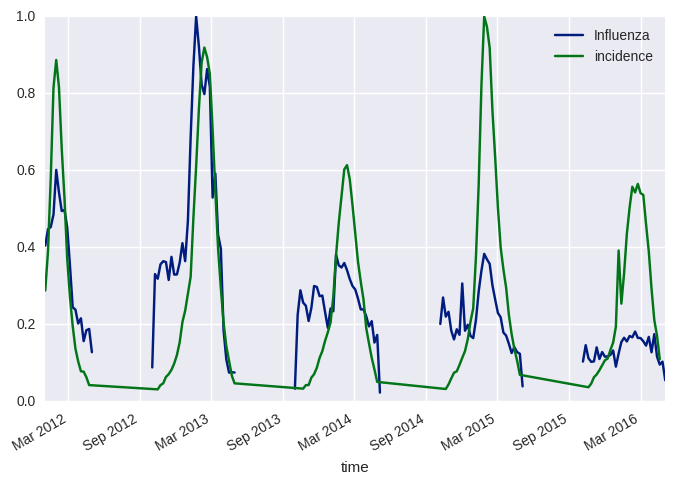

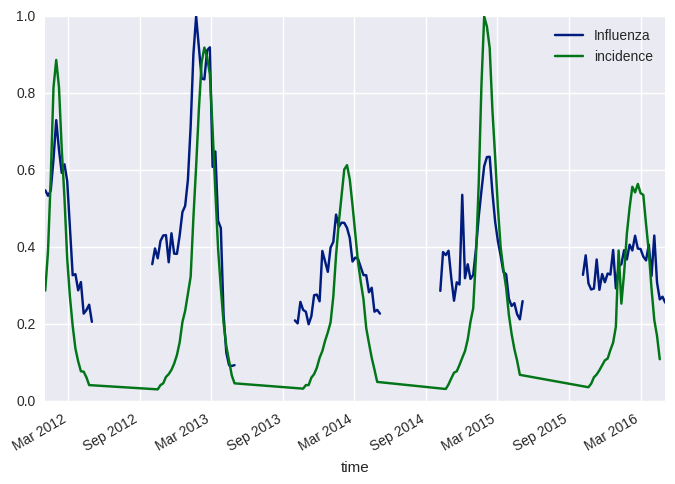

Not scaled: (0.5971879515914595, 8.7144921281547, 4.3298697960381105e-15)
Scaled: (0.7569993291035382, 13.560204653074411, 0.0)


In [63]:
def comparePlots(influnet, wikis, year):
    gt = influnet["incidence"][influnet.index.year > year]
    gt = gt/max(gt)
    for wiki in wikis:
        y = wikis[wiki][wikis.index.year > year]
        y = y/max(y)
        plt.plot(y),gt.plot()
        plt.legend()
        plt.show() 
        
def crossCorrelation(x,y):
    num = np.mean((x-np.mean(x))*(y-np.mean(y)))
    den = np.std(x)*np.std(y)
    r = num/den
    #print len(x), len(y)
    
    #significance
    n = len(x)
    t = r * ((n-2)/(1-r**2))**(0.5)
    pvalue = 1-scipy.stats.t.cdf(t, n-2)        
    
    return r,t,pvalue


df_wikis2 = df_wikis.div(df_wikis.totalViews, axis='index')
del df_wikis2["totalViews"] 
del df_wikis["totalViews"] 



comparePlots(df_influnet, pd.DataFrame(df_wikis["Influenza"]), 2011)
comparePlots(df_influnet, pd.DataFrame(df_wikis2["Influenza"]), 2011)

print "Not scaled:", crossCorrelation(df_influnet['incidence'][df_influnet.index >= min(df_wikis.index)], df_wikis["Influenza"])
print "Scaled:", crossCorrelation(df_influnet['incidence'][df_influnet.index >= min(df_wikis2.index)], df_wikis2["Influenza"])

From the computation of the crosscorrelation we derive that scaling by the total views increases sensibilty the correlation of the two phenomena. The t-test on the data show that the two  phenomena are  clearly generated by the same phenomena.

# 2 - Other functions



At this point we are intrested to find if there is any other wikipedia pages that are able to gives us a better insghit about the topics. In order to get those pages we have used a systematic approach: starting from the *influneza* page, we use any other web page that is present on the top header of the page.
From this approach we have added the following pages:

* 
*
*

In addition to this we consulted google adwords in order to find correlated keywords. we have found that the following keywords are the most correlated

* 
*
*

To this systematic approach we have also used some intuition and added the following keywords:

*
*
*

### 2.1 Subsection

At this point we check the plots of the different pages and

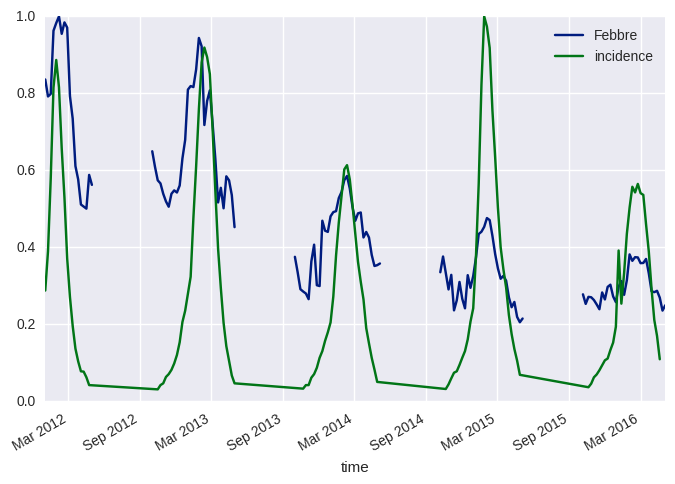

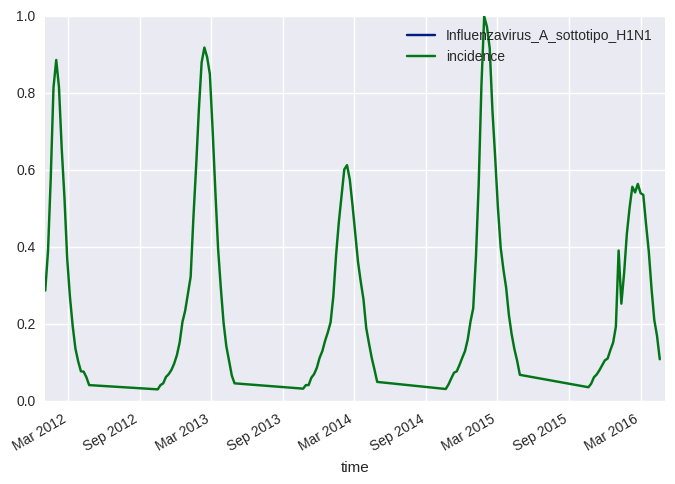

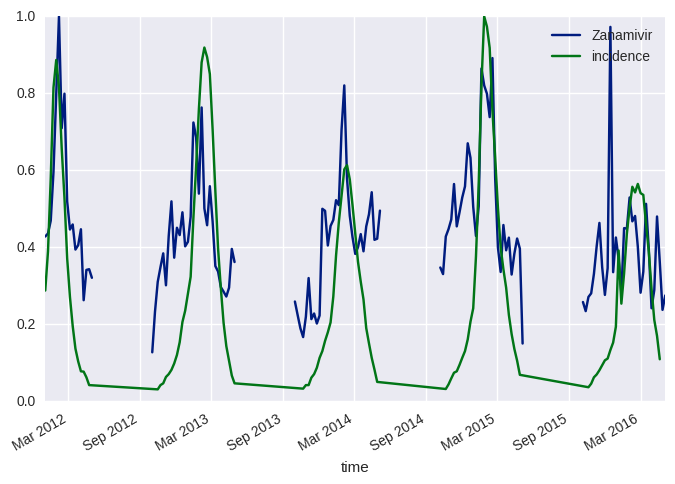

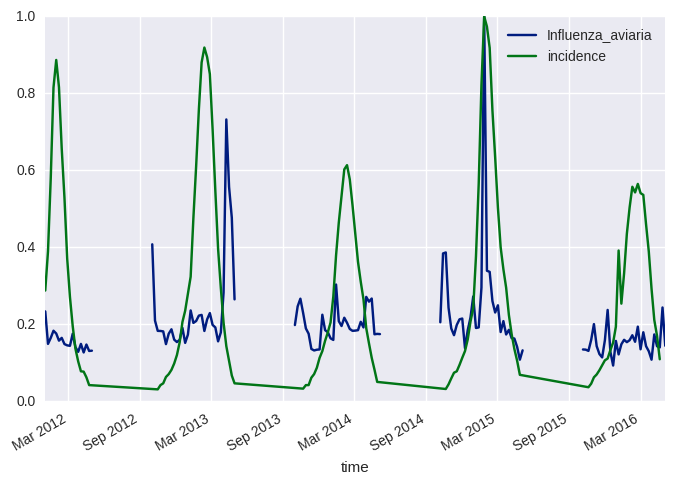

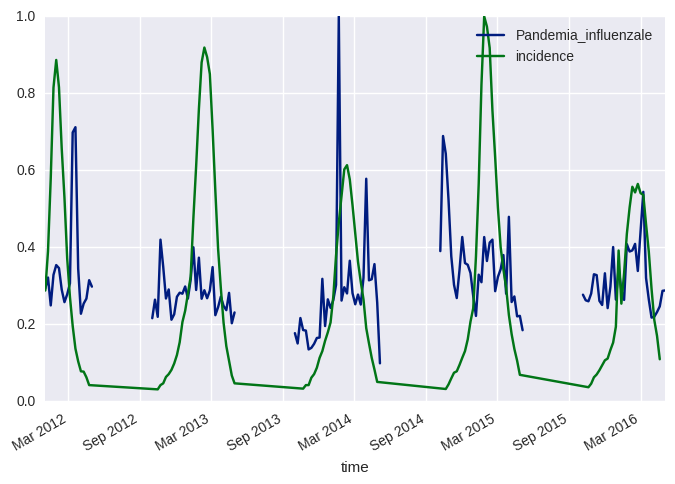

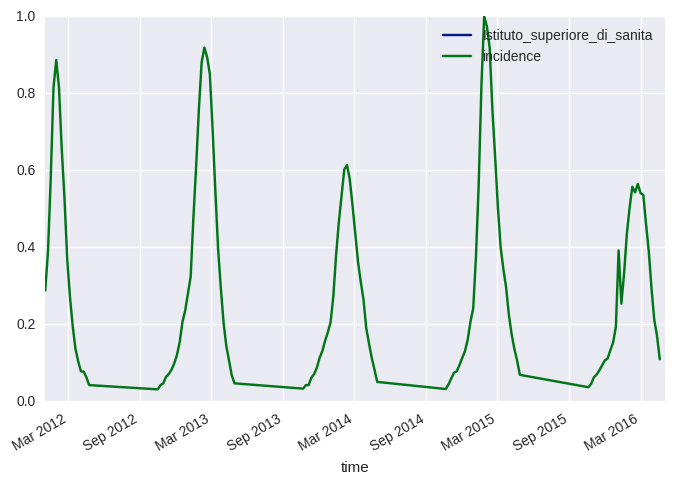

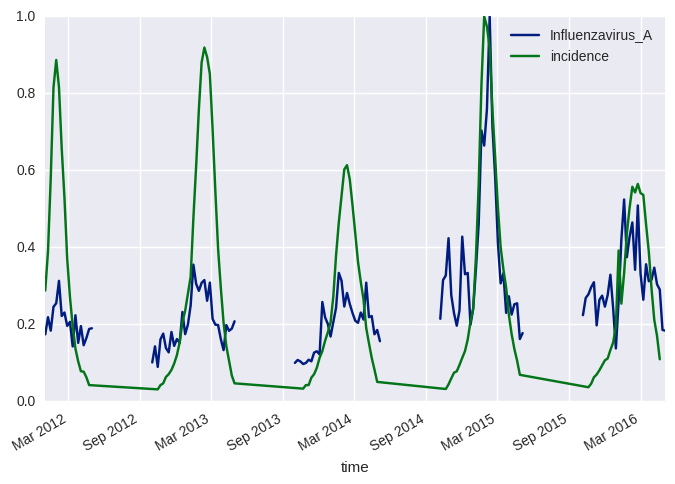

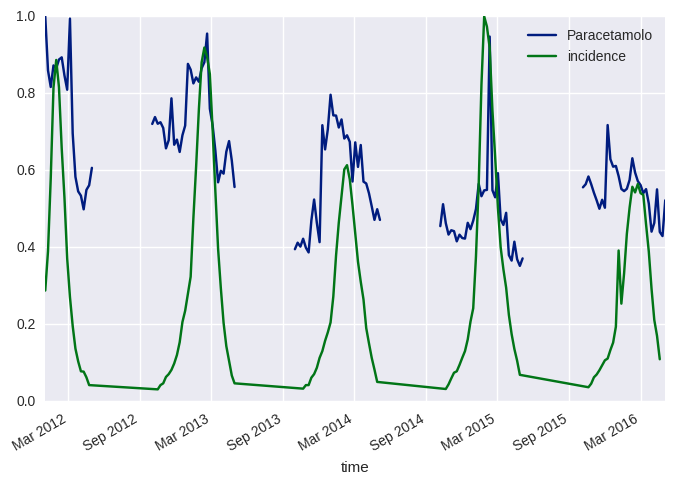

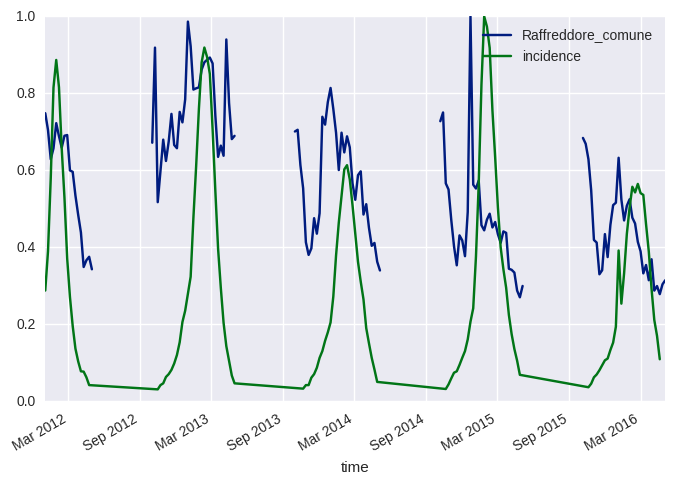

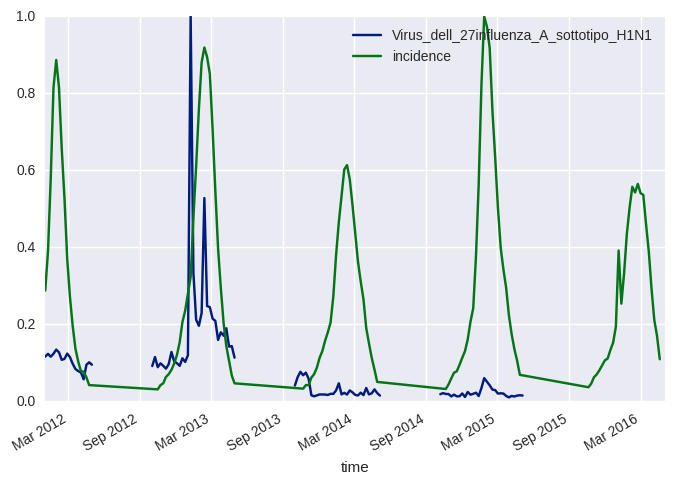

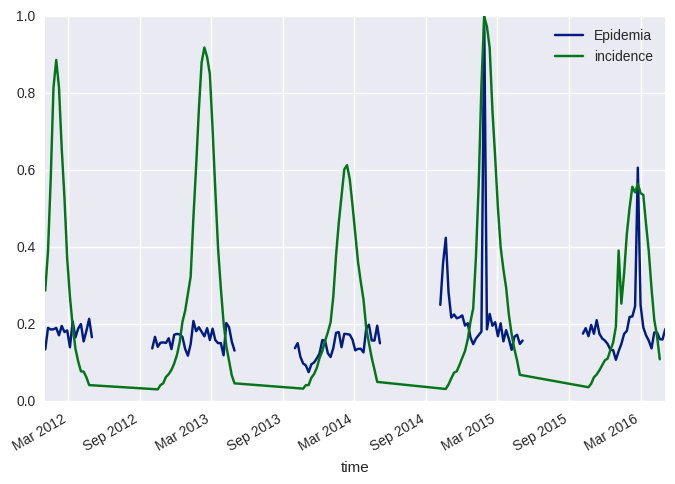

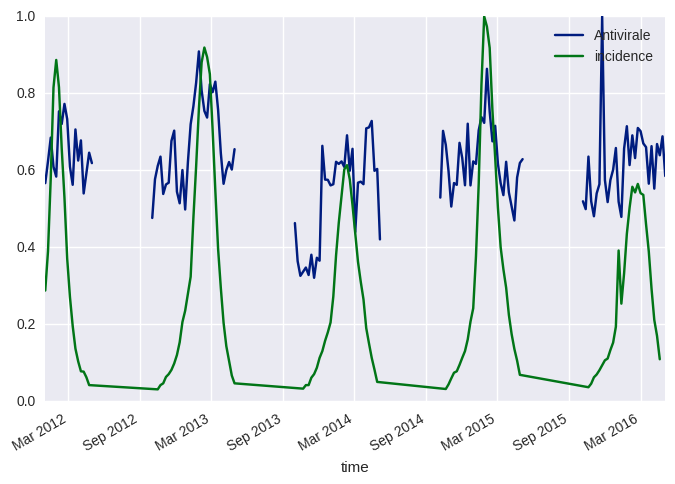

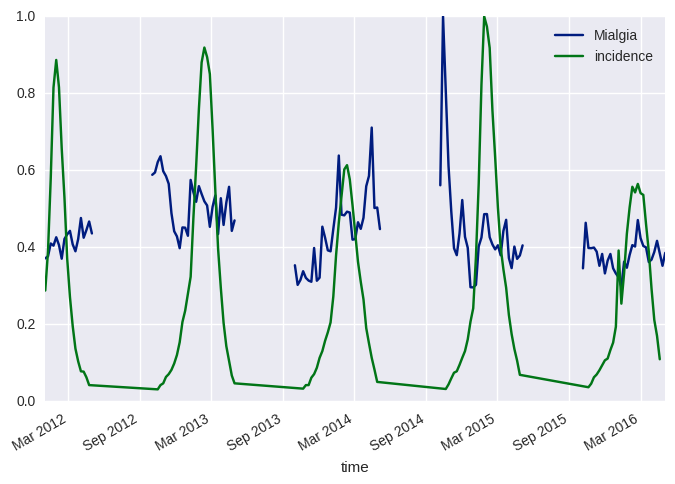

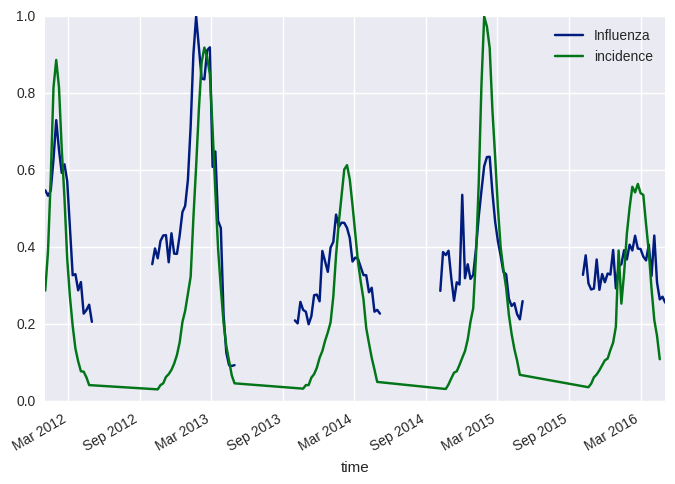

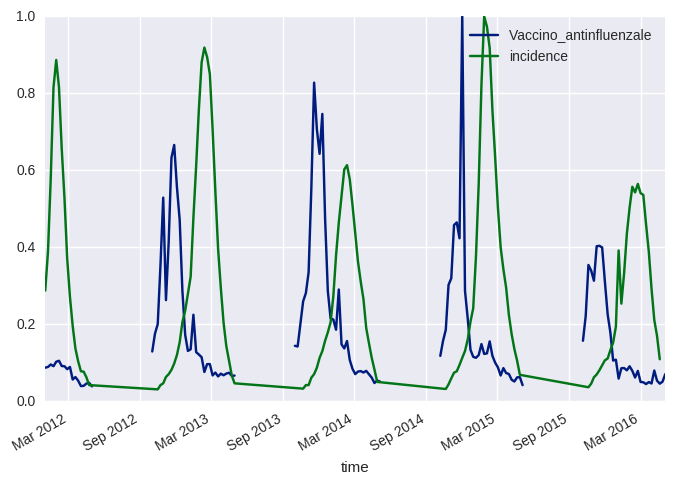

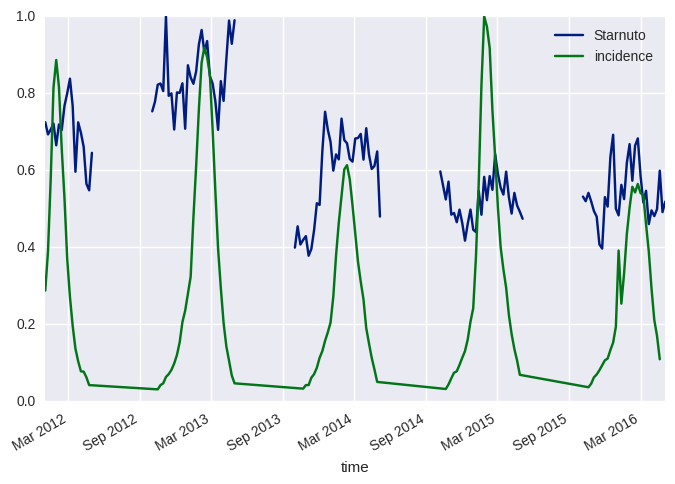

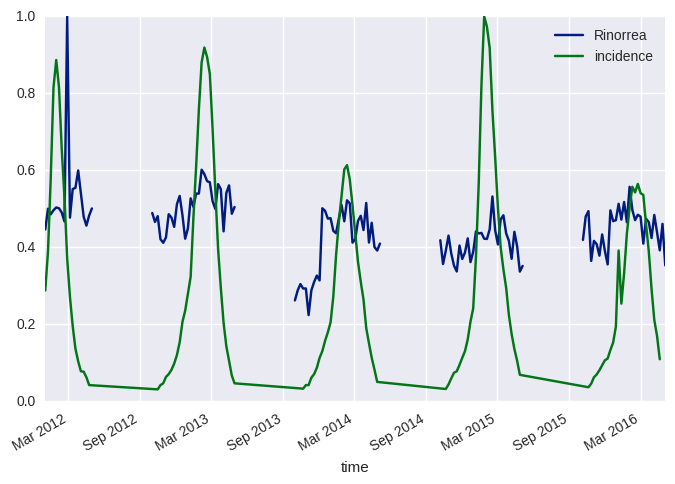

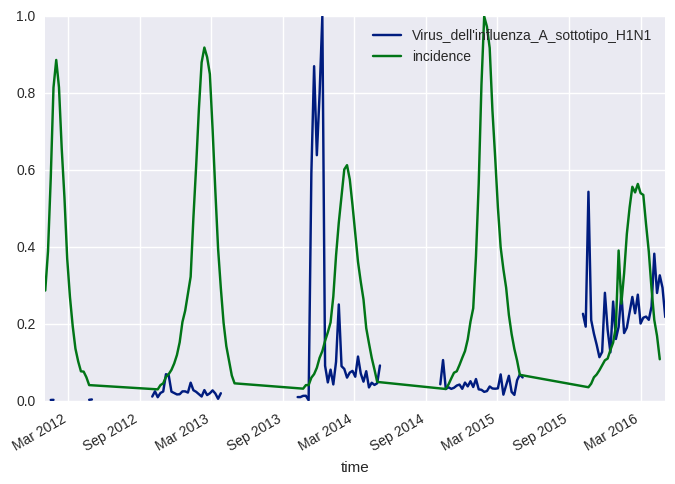

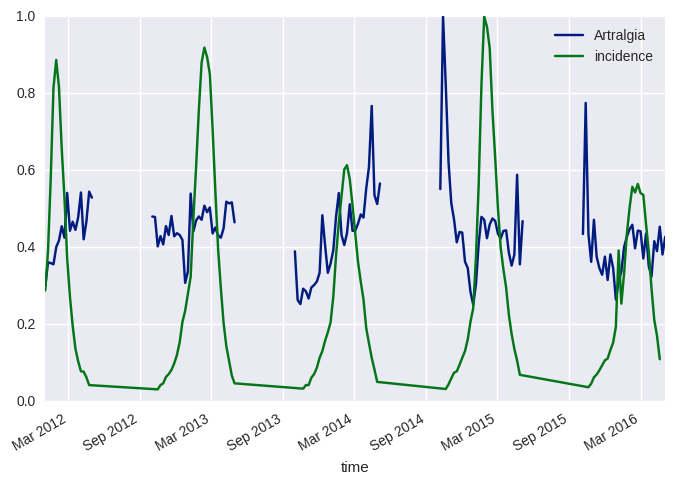

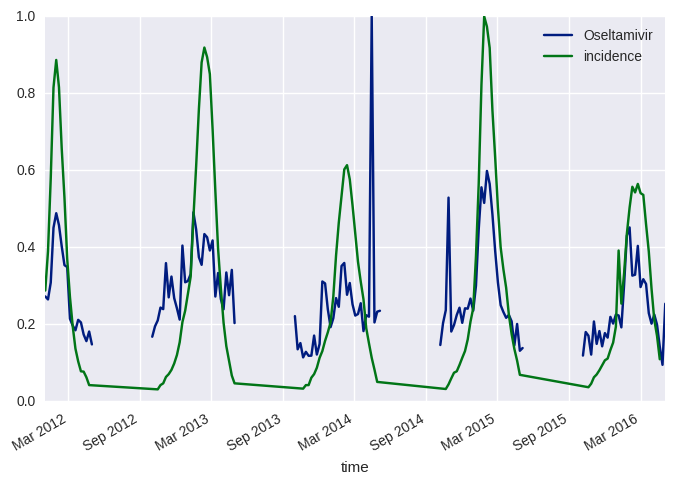

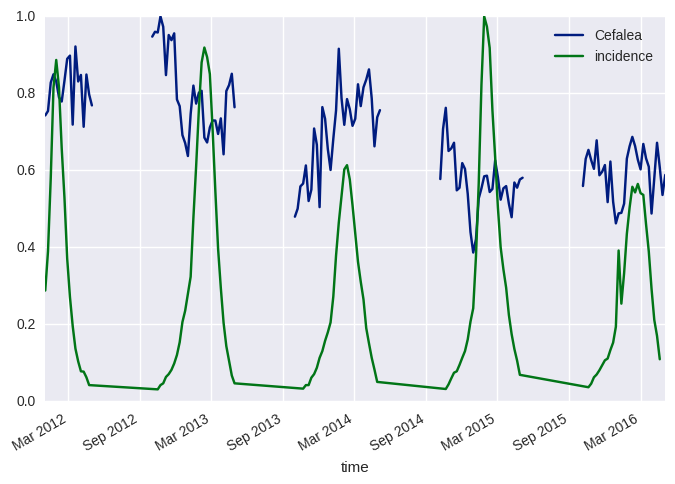

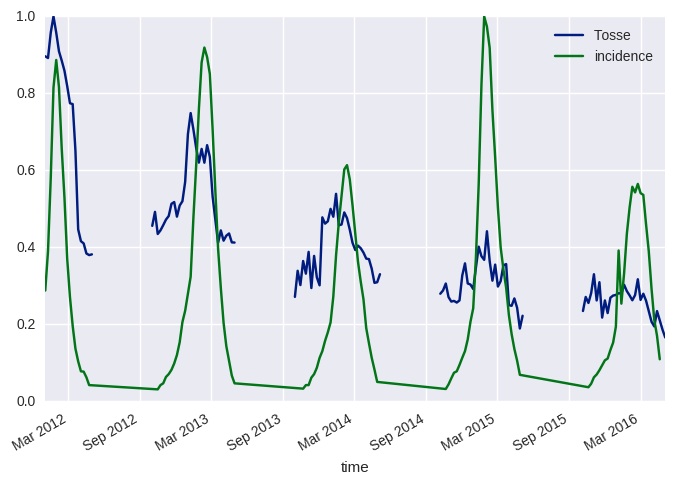

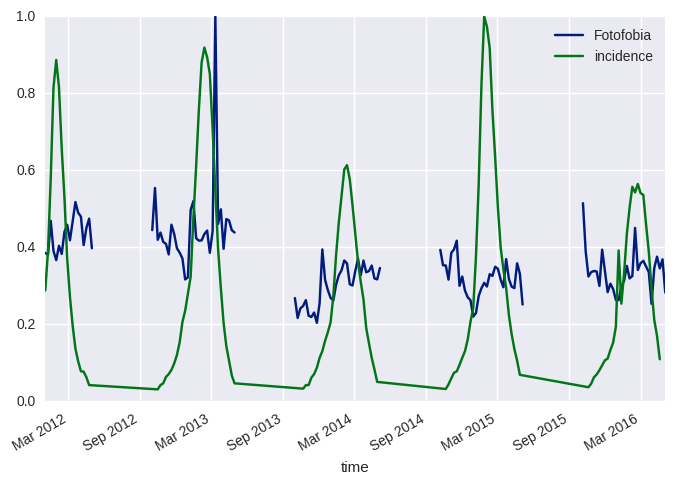

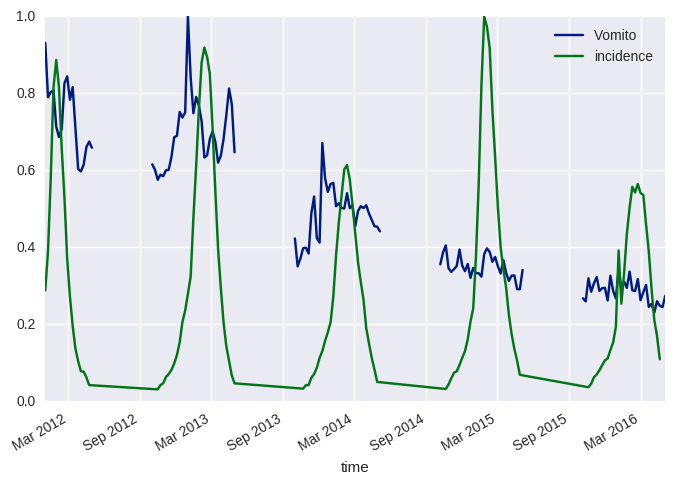

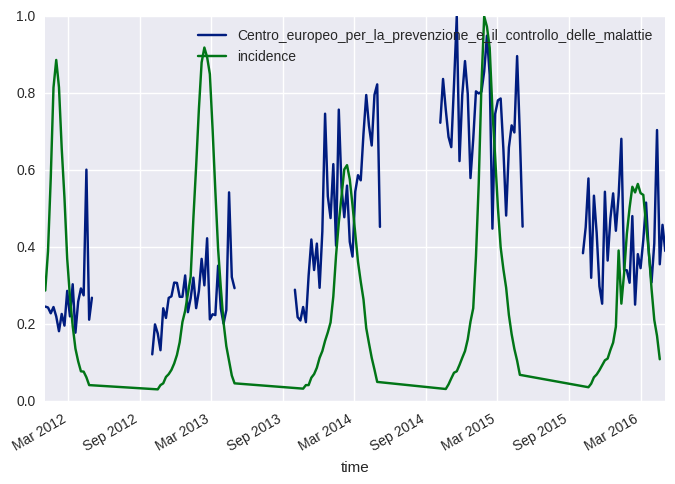

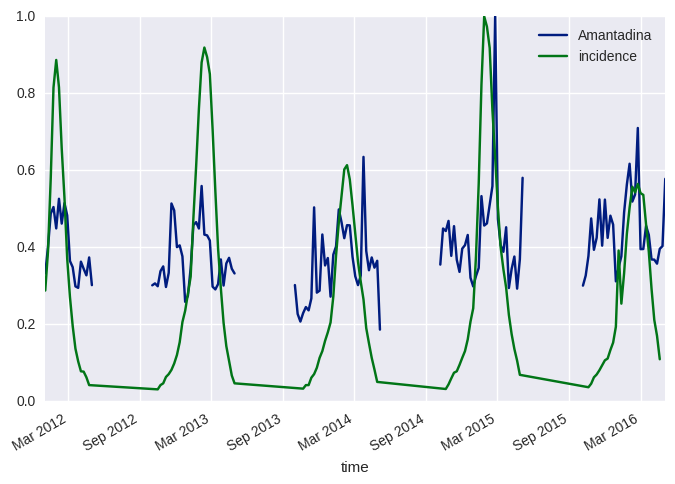

In [6]:
comparePlots(df_influnet, df_wikis2, 2011)

From the plots is hard to understand if including the totalView is actually beneficial for all the features. In order to get a better insight we compute the crosscorrelation between the influnet data and each other.

In [7]:
def getCorrelations(influnet, wiki):
    correlations = {}
    for w in wiki:
        correlations[w] = crossCorrelation(influnet['incidence'][influnet.index >= min(wiki[w].index)], wiki[w])[0]
    return [[e[0],float(e[1])] for e in sorted(correlations.items(), key=operator.itemgetter(1), reverse=True)]

corr1 = getCorrelations(df_influnet, df_wikis)
corr1


[['Influenzavirus_A', 0.7096513029594593],
 ['Influenzavirus_A_sottotipo_H1N1', 0.666407493485712],
 ['Influenza', 0.5971879515914595],
 ['Oseltamivir', 0.5572230553342197],
 ['Zanamivir', 0.5496059043324545],
 ['Amantadina', 0.3948812248923687],
 ['Antivirale', 0.3854415217890175],
 ['Febbre', 0.38537921062908115],
 ['Epidemia', 0.3324751458601887],
 ['Paracetamolo', 0.3165921104573874],
 ['Virus_dell_27influenza_A_sottotipo_H1N1', 0.26982970001828505],
 ['Tosse', 0.2592478922896606],
 ['Rinorrea', 0.2567339292286467],
 ['Raffreddore_comune', 0.24411682141552352],
 ['Pandemia_influenzale', 0.21142548906963524],
 ['Influenza_aviaria', 0.19974279046305934],
 ['Starnuto', 0.19429403167295803],
 ['Artralgia', 0.1388357836426447],
 ['Fotofobia', 0.12349220238182526],
 ['Mialgia', 0.11875203587854465],
 ['Vomito', 0.11172757202500445],
 ['Centro_europeo_per_la_prevenzione_e_il_controllo_delle_malattie',
  0.06281842665101425],
 ['Cefalea', 0.01610215468418847],
 ['Istituto_superiore_di_sani

### 2.2  Subsection

During the previous sections we did not explictly address this point, but is the total views 

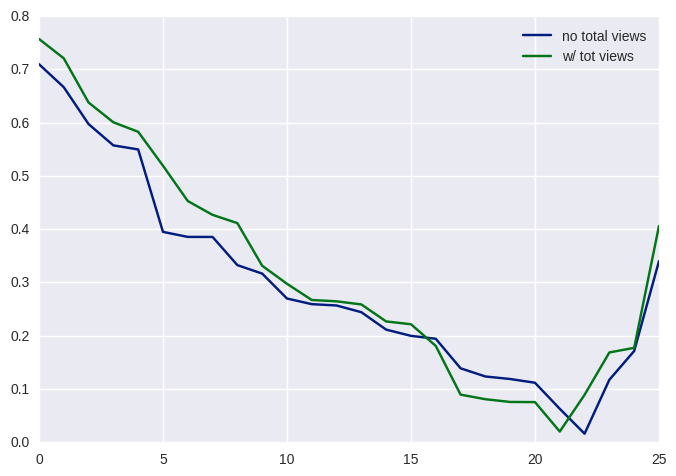

In [8]:
def compareCorrelations(d1, n1, d2, n2):
    corr1, corr2 = getCorrelations(df_influnet, d1), getCorrelations(df_influnet, d2)
    no2 = pd.DataFrame([])
    no2[n1] = np.absolute(pd.DataFrame(corr1)[1])
    no2[n2]  = np.absolute(pd.DataFrame(corr2)[1])
    no2.plot()
    plt.show()

compareCorrelations(df_wikis, "no total views", df_wikis2, "w/ tot views")

From the plot we can deduce that infact the pageviews factor improves the correlation of the covariates sensibly. We do not care about the actual variables, we are just intrested in the expressivness ranking in term of correlation. Morever since we are  intrested both in negative and positive correlation to perform our analysis we took the absulute value. From the plot above is clear that including the total views count increase sensibly the correlation in both the negative and positive correlated variables. This effect effect vanished for the less correlated variables, with values $-0.2 <corr < 0.2$ where is dominated by the noise.

Given this fact from now on we are going to include the total views in our predictions in exercise 3.


In [64]:
df_wikis = df_wikis2

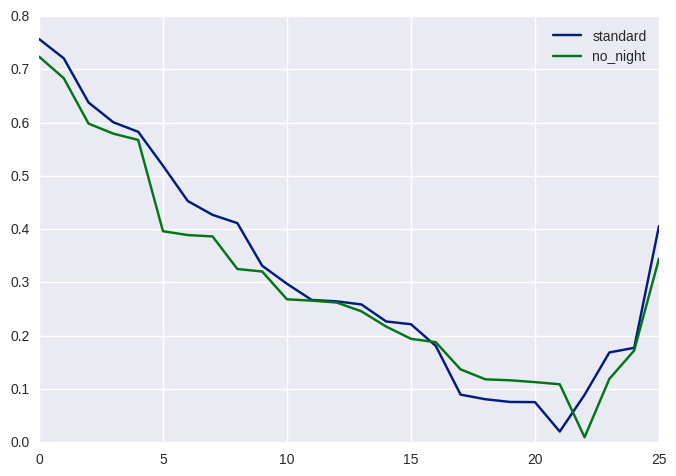

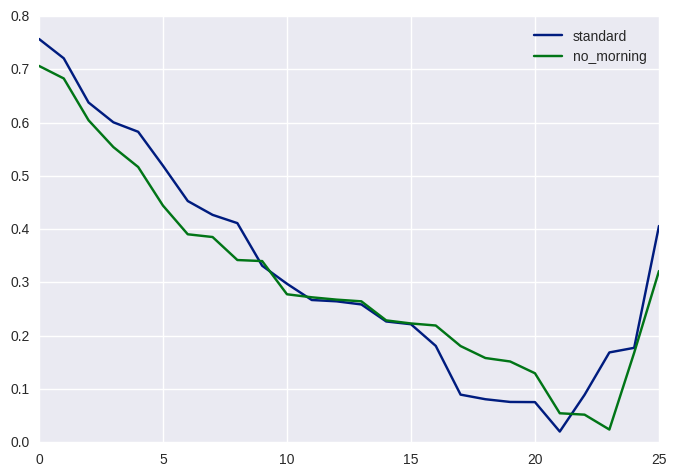

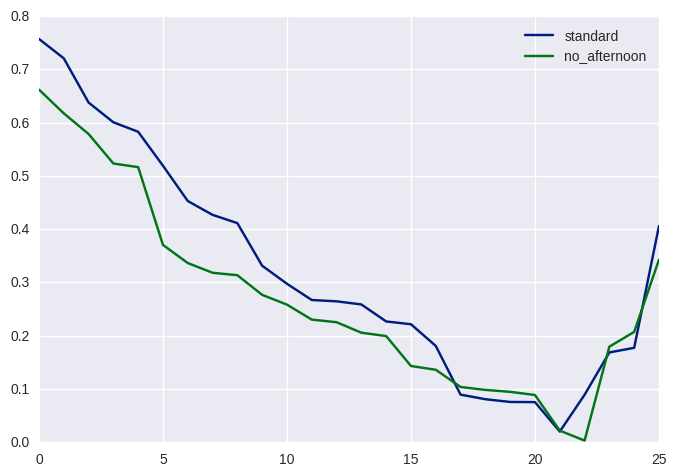

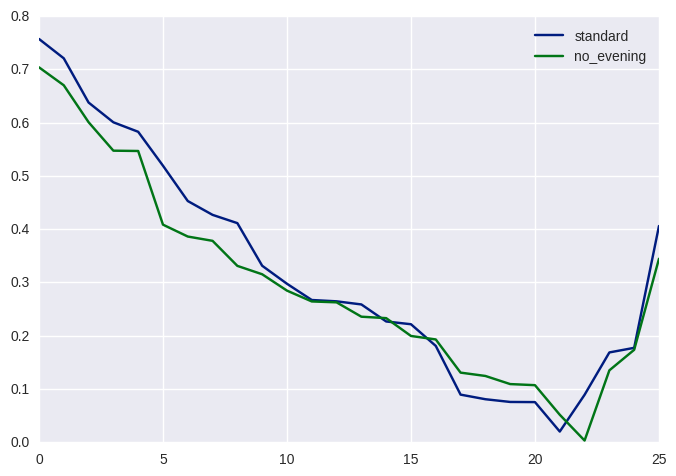

In [10]:
no_night = getWiki(data, night=False)
del no_night["totalViews"]
compareCorrelations(df_wikis, "standard", no_night, "no_night")

no_morning = getWiki(data, morning=False)
del no_morning["totalViews"]
compareCorrelations(df_wikis, "standard", no_morning, "no_morning")

no_afternoon = getWiki(data, afternoon=False)
del no_afternoon["totalViews"]
compareCorrelations(df_wikis, "standard", no_afternoon, "no_afternoon")

no_evening = getWiki(data, evening=False)
del no_evening["totalViews"]
compareCorrelations(df_wikis, "standard", no_evening, "no_evening")

From those plots we see that none of the previous arrangements considerably improve  the correlations. So for the prediction stage we are  going to exploit just the previous scaling with total views.

## 3 - Section

In this section we are going to focus on flu prediction. To estimate flu seasonal outbreaks we used several regression models, that we trained using Wikipedia's pagegivews. We begin our analysis by starting with simple linear model as:

* Linear Regression
* Lasso 
* Elastic Net Regressor

We than proceed in our analysis by tring different non linear regressors. For every model we are going to perform parameters selection to understand which parameters are more relevant in order to undestand and cross-validation to find the best parameters. The models are:

* SVM

After this first phase we are going to add to more parameters to our analys:

* Influnet incidence for the week precdiing the target week
* pageviews counts for all the pages that you selected for the week preceeding the target week

and check how good performance increases.


### 3.1 Linear Models

Now we are going to use lasso. After all a Lasso is nothing else than a Elastic net with 

The Lasso is a linear model that estimates sparse coefficients. It is useful in some contexts due to its tendency to prefer solutions with fewer parameter values, effectively reducing the number of variables upon which the given solution is dependent. For this reason, the Lasso and its variants are fundamental to the field of compressed sensing. Under certain conditions, it can recover the exact set of non-zero weights (see Compressive sensing: tomography reconstruction with L1 prior (Lasso)).
Mathematically, it consists of a linear model trained with \ell_1 prior as regularizer. The objective function to minimize is:

$\underset{w}{min\,} { \frac{1}{2n_{samples}} ||X w - y||_2 ^ 2 + \alpha ||w||_1}$

The lasso estimate thus solves the minimization of the least-squares penalty with \alpha ||w||_1 added, where \alpha is a constant and ||w||_1 is the \ell_1-norm of the parameter vector.
The implementation in the class Lasso uses coordinate descent as the algorithm to fit the coefficients. See Least Angle Regression for another implementation:

In [11]:
def PrintPrediction(X_test, Y_test, Y_hat):
    
    alpha = X_test.index[0]
    omega = X_test.index[-1]
    time_range = pd.date_range(alpha, omega, freq='W-TUE')

    Y_hat = Y_hat.reindex(time_range, fill_value= np.nan)
    Y_test = Y_test.reindex(time_range, fill_value= np.nan)


    line_Y, = plt.plot(Y_hat.index, Y_test['incidence'], label="Y",  linestyle='-')
    line_hat, = plt.plot(Y_hat.index, Y_hat,linestyle='-', label = "Y_hat")
    plt.legend(handles=[line_Y, line_hat])
    plt.show()
    

In [12]:
def LassoPrediction(X_train, Y_train, X_test, Y_test):
    CVlassoreg = LassoCV(alphas = [.0001, .5, 10,1000,0.00000000001],eps = 1e-1000, cv=50, fit_intercept=False)
    CVlassoreg.fit(X_train.values, Y_train['incidence'].values)
    Y_hat = pd.DataFrame(CVlassoreg.predict(X_test.values), index= X_test.index)
    Y_hat[Y_hat<0] = 0
    print(len(X_test.index),len(Y_hat), len(Y_test['incidence'].values))
    rms = sqrt(mean_squared_error(Y_test['incidence'].values, Y_hat))
    PrintPrediction(X_test, Y_test, Y_hat)
    return rms, CVlassoreg.get_params()


In [13]:
def ElasticNetPrediction(X_train, Y_train, X_test, Y_test):
    CVelasticreg = ElasticNetCV(l1_ratio=0.9, normalize=False,alphas = [.0001, .5, 10],eps = 1e-1000, cv=50, fit_intercept=False)
    CVelasticreg.fit(X_train.values, Y_train['incidence'].values)
    Y_hat = pd.DataFrame(CVelasticreg.predict(X_test.values), index= X_test.index)
    Y_hat[Y_hat<0] = 0
    print(len(X_test.index),len(Y_hat), len(Y_test['incidence'].values))
    rms = sqrt(mean_squared_error(Y_test['incidence'].values, Y_hat))
    PrintPrediction(X_test, Y_test, Y_hat)
    return rms, CVelasticreg.get_params()
    

In [14]:
def SVRPrediction(X_train, Y_train, X_test, Y_test):
    SVreg = SVR(C=10, epsilon=0.1)
    SVreg.fit(X_train.values, Y_train['incidence'].values)
    Y_hat = pd.DataFrame(SVreg.predict(X_test.values), index= X_test.index)
    Y_hat[Y_hat<0] = 0
    print(len(X_test.index),len(Y_hat), len(Y_test['incidence'].values))
    rms = sqrt(mean_squared_error(Y_test['incidence'].values, Y_hat))
    PrintPrediction(X_test, Y_test, Y_hat)
    return rms, SVreg.get_params()
    

In [58]:
df_wikis["incidence"] = df_influnet["incidence"]
wimp = df_wikis.fillna(0)

iimp = pd.DataFrame(wimp["incidence"], columns=["incidence"], index=df_wikis.index)
del wimp["incidence"]
wimp

,Febbre,Influenzavirus_A_sottotipo_H1N1,Zanamivir,Influenza_aviaria,Pandemia_influenzale,Istituto_superiore_di_sanita,Influenzavirus_A,Paracetamolo,Raffreddore_comune,Virus_dell_27influenza_A_sottotipo_H1N1,...,Virus_dell'influenza_A_sottotipo_H1N1,Artralgia,Oseltamivir,Cefalea,Tosse,Fotofobia,Vomito,Centro_europeo_per_la_prevenzione_e_il_controllo_delle_malattie,Amantadina,totalViews
Date,,,,,,,,,,,,,,,,,,,,,
2011-10-04,2330.0,0.0,21.0,208.0,44.0,0.0,36.0,2409.0,1069.0,153.0,...,1.0,232.0,51.0,963.0,790.0,212.0,925.0,12.0,83.0,69449545.0
2011-10-11,3512.0,0.0,38.0,308.0,81.0,0.0,51.0,4081.0,1873.0,315.0,...,0.0,350.0,77.0,1500.0,1337.0,377.0,1512.0,28.0,170.0,103942934.0
2011-10-18,3500.0,0.0,62.0,300.0,108.0,0.0,88.0,4395.0,2081.0,317.0,...,3.0,382.0,126.0,1620.0,1579.0,386.0,1708.0,42.0,147.0,94979078.0
2011-10-25,3504.0,0.0,60.0,300.0,105.0,0.0,67.0,4483.0,1748.0,288.0,...,2.0,397.0,97.0,1509.0,1717.0,423.0,1759.0,32.0,159.0,93326583.0
2011-11-01,3659.0,0.0,64.0,334.0,99.0,0.0,76.0,4799.0,1710.0,334.0,...,0.0,389.0,105.0,1715.0,2049.0,460.0,1914.0,37.0,213.0,102709603.0
2011-11-08,4235.0,0.0,63.0,317.0,95.0,0.0,109.0,5112.0,1799.0,377.0,...,0.0,474.0,129.0,2349.0,2279.0,607.0,2189.0,27.0,232.0,111489897.0
2011-11-15,4053.0,0.0,52.0,354.0,86.0,0.0,78.0,4900.0,1614.0,423.0,...,1.0,475.0,124.0,2166.0,2163.0,595.0,2099.0,30.0,213.0,108261915.0
2011-11-22,4316.0,0.0,70.0,377.0,93.0,0.0,88.0,4882.0,1797.0,341.0,...,1.0,460.0,114.0,2014.0,2257.0,544.0,2138.0,32.0,306.0,106003857.0
2011-11-29,4225.0,0.0,68.0,825.0,126.0,0.0,120.0,6460.0,1798.0,545.0,...,0.0,440.0,153.0,2222.0,2228.0,535.0,2438.0,32.0,224.0,104224941.0


In [43]:
print len(iimp), len(wimp)

18 18


Each of those function uses crossvalidation to find the best parameter.

209 209 209 209
LASSO: (209, 209, 209)


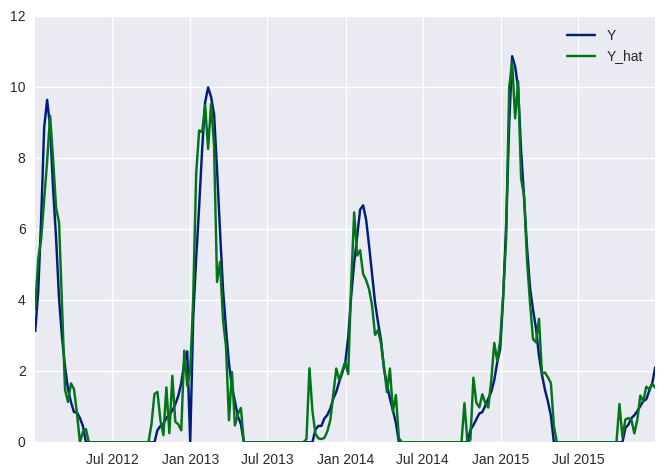

(0.6850065471154719, {'normalize': False, 'alphas': [0.0001, 0.5, 10, 1000, 1e-11], 'n_jobs': 1, 'verbose': False, 'fit_intercept': False, 'selection': 'cyclic', 'positive': False, 'n_alphas': 100, 'max_iter': 1000, 'eps': 0.0, 'precompute': 'auto', 'random_state': None, 'tol': 0.0001, 'copy_X': True, 'cv': 50})
ELASTIC_NET: (209, 209, 209)


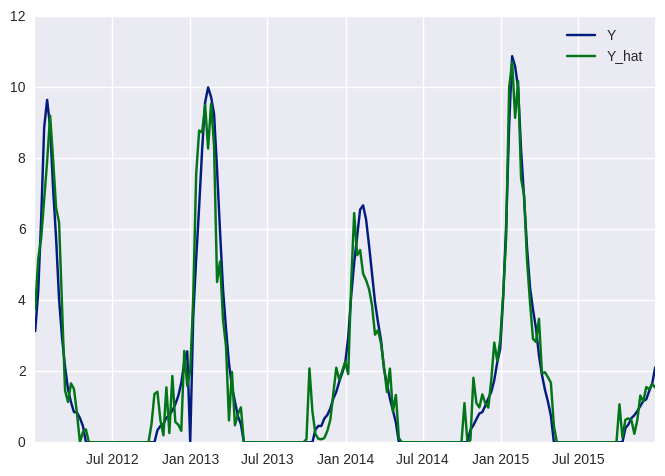

(0.684581701113611, {'normalize': False, 'alphas': [0.0001, 0.5, 10], 'n_jobs': 1, 'verbose': 0, 'fit_intercept': False, 'selection': 'cyclic', 'l1_ratio': 0.9, 'n_alphas': 100, 'max_iter': 1000, 'eps': 0.0, 'precompute': 'auto', 'random_state': None, 'tol': 0.0001, 'positive': False, 'copy_X': True, 'cv': 50})
SVR: (209, 209, 209)


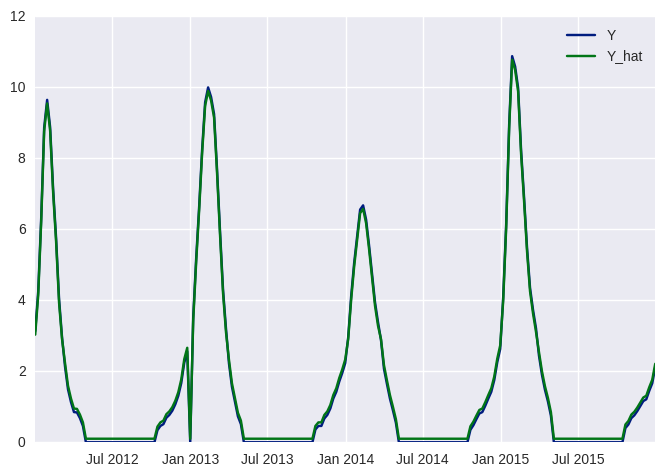

(0.09948929082092327, {'kernel': 'rbf', 'C': 10, 'verbose': False, 'degree': 3, 'epsilon': 0.1, 'shrinking': True, 'max_iter': -1, 'tol': 0.001, 'cache_size': 200, 'coef0': 0.0, 'gamma': 'auto'})


In [66]:
X_train,Y_train = wimp[(wimp.index.year > 2011) & (wimp.index.year < 2016)], iimp[(iimp.index.year > 2011) & (iimp.index.year < 2016)]  
X_test, Y_test  = wimp[(wimp.index.year == 2015)], iimp[(iimp.index.year == 2015)]

X_test, Y_test = wimp[(wimp.index.year > 2011) & (wimp.index.year < 2016)], iimp[(iimp.index.year > 2011) & (iimp.index.year < 2016)]  


print len(X_train),len(Y_train), len(X_test), len(Y_test)




print "LASSO:", LassoPrediction(X_train, Y_train, X_test, Y_test)
print "ELASTIC_NET:",ElasticNetPrediction(X_train, Y_train, X_test, Y_test)

print "SVR:", SVRPrediction(X_train, Y_train, X_test, Y_test)






221 221 221 221
(221, 221, 221)


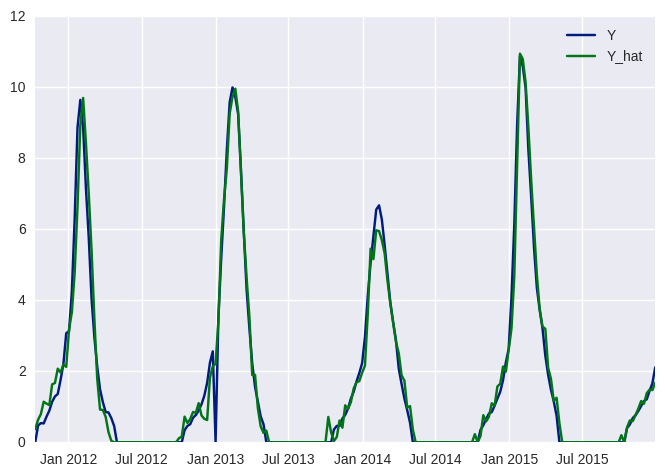

(221, 221, 221)


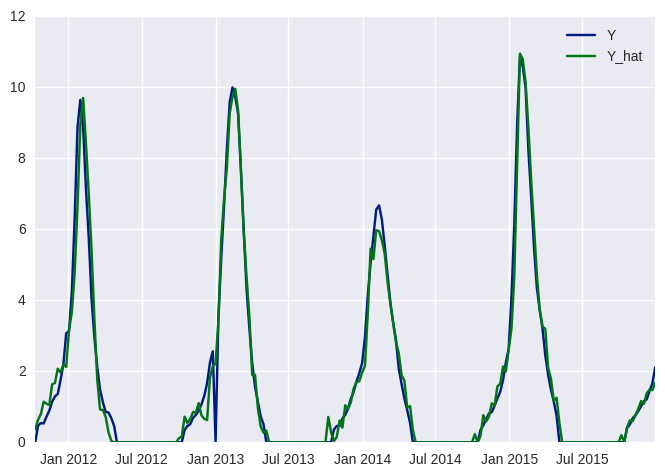

(221, 221, 221)


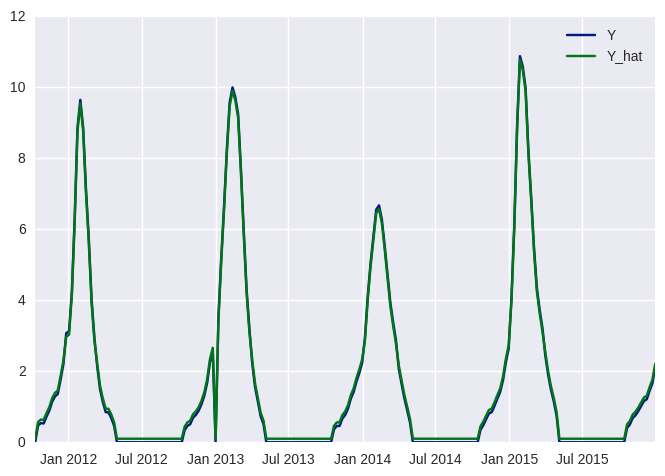

(0.10003745627634608,
 {'C': 10,
  'cache_size': 200,
  'coef0': 0.0,
  'degree': 3,
  'epsilon': 0.1,
  'gamma': 'auto',
  'kernel': 'rbf',
  'max_iter': -1,
  'shrinking': True,
  'tol': 0.001,
  'verbose': False})

In [68]:
tWeek = X_test.index[-1]

wshift = wimp
wshift["incidence"] =  iimp["incidence"]
Y_predict = wshift["incidence"][wshift["incidence"].index.date == tWeek]
wshift["incidence"] = wshift["incidence"].shift(1)
ishift = iimp
wshift = wshift.drop(wshift.index[0]) #remove first row
ishift = ishift.drop(ishift.index[0])

X_train,Y_train = wshift[(wshift.index.year > 2007) & (wshift.index.year < 2016)], ishift[(ishift.index.year > 2007) & (ishift.index.year < 2016)]  
X_test, Y_test  = wshift[(wshift.index.year == 2012)], ishift[(ishift.index.year == 2012)]
X_test, Y_test = wshift[(wshift.index.year > 2007) & (wshift.index.year < 2016)], ishift[(ishift.index.year > 2007) & (ishift.index.year < 2016)]  


print len(X_train),len(Y_train), len(X_test), len(Y_test)
LassoPrediction(X_train, Y_train, X_train,Y_train)
ElasticNetPrediction(X_train, Y_train, X_test, Y_test)
SVRPrediction(X_train, Y_train, X_train,Y_train)

We are now intrested in building a better estimation for our model, so we will use in this case two more features.

* Incidence for the previous week
* Pages contus 

In [ ]:
def getHeatMap(elems, years):
    '''
    :param elems: 
    :param years: 
    :return: 
    '''
    y = len(years)
    heatmap = pd.DataFrame(np.zeros(y**2).reshape(y,y), index = years, columns=years)
    
    for y1 in years:
        for y2 in years:
            #print("ciao",elems[0][elems[0].index.year == year1])
            a = elems[0][elems[0].index.year == y1]
            a = a["incidence"]/max(a["incidence"])
            b = elems[1][elems[1].index.year == y2]
            b = b/max(b)
            minimum = min(len(a), len(b))
            heatmap.ix[y1,y2] = pearsonr(a[:minimum].values, b[:minimum].values)[0]
    print heatmap
    sb.heatmap(heatmap)
    plt.show()

In [ ]:
print(X_train.index, influnet["incidence"].index)

In [ ]:
influnet_raw = importInflunet("/home/aalto/Desktop/DE/hw2/influnet/data/")
influnet_raw = influnet_raw[(influnet_raw.index.year > 2007) & (influnet_raw.index.year < 2016)]


wikis = getWikis()
wikis = wikis[(wikis.index.year > 2007) & (wikis.index.year < 2016)]


keep =  influnet_raw["incidence"].notnull().values
influnet = influnet_raw[keep]
wikis = wikis[keep]



#for wiki in wikis:
    #plt.plot(influnet/max(influnet["incidence"]))
    #plt.plot(wikis[wiki]/max(wikis[wiki]))
    #plt.show()

In [97]:
tWeek = X_test.index[-1]

wikis["incidence"] =  influnet["incidence"]
Y_predict = wikis["incidence"][wikis["incidence"].index.date == tWeek]
wikis["incidence"] = wikis["incidence"].shift(1)

wikis = wikis.drop(wikis.index[0]) #remove first row
print wikis

X_train,Y_train = wikis[(wikis.index.year > 2008) & (wikis.index.year < 2015)], influnet[(influnet.index.year > 2008) & (influnet.index.year < 2015)]  
X_test, Y_test  = wikis[(wikis.index.year == 2015)], influnet[(influnet.index.year == 2015)]

LassoPrediction(X_train, Y_train, X_test, Y_test)
ElasticNetPrediction(X_train, Y_train, X_test, Y_test)

            Febbre  Influenzavirus_A_sottotipo_H1N1  Zanamivir  \
Date                                                             
2011-10-25  3504.0                              NaN       60.0   
2011-11-01  3659.0                              NaN       64.0   
2011-11-08  4235.0                              NaN       63.0   
2011-11-15  4053.0                              NaN       52.0   
2011-11-22  4316.0                              NaN       70.0   
2011-11-29  4225.0                              NaN       68.0   
2011-12-06  4378.0                              NaN       75.0   
2011-12-13  4266.0                              NaN       99.0   
2011-12-20  4311.0                              NaN       58.0   
2011-12-27  2299.0                              NaN       38.0   
2012-01-03  5518.0                              NaN       70.0   
2012-01-10  5938.0                              NaN       81.0   
2012-01-17  5908.0                              NaN       86.0   
2012-01-24

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

### 2.2 Reprise

We are now going to use the previous filtered dataset in order to check if our model improves filtering out portion of the data which itroduce noise.

# Extra Point

At this point we need the wikipedia pages views count in order to compare them with influnet. In order to satisy the requirement for the bonus point I wrote a simple script that downloads the files from https://dumps.wikimedia.org/, scan it to find the words we are intrested in and writes those entries of the files that we are intrested and write them on different files. 

Once those files are collected and stored on our disk we can call this function which loads the element passed them in memoery and group them by week.


# Stuff

In [ ]:
def padInflunet(aux, year):
    '''
    The influnet dataset lacks information about the weeks that do not belog to the flu season (usally, but not necessarly, from week 17 to 40).
    This functions fills the dataset with empty position in order to match the wikipedia format.
    
    :param aux: Influnet dataframe from a specific year
    :param year: year of the previous Influnet dataframe
    :return: padded version of the original dataframe
    '''
    year_weeks = aux.index.values[-1]
    week_range = range(1,year_weeks+1)
    aux = aux.reindex(week_range, fill_value=0)
    aux["year"] = year
    aux["week"] = week_range
    
    aux.set_index(['year', 'week'], append=False, inplace=True)
    return aux


def getInflunet(path = "/home/aalto/Desktop/DE/hw2/influnet/data/"):
    '''
    import and reformat the original Influnet dataset
    
    :param path: 
    :return: clean and padded version of the Influnet dataset
    '''
    
    df = importInflunet();
    previous = None
    for x,y in df.index.values:
        if previous == None:
            df2 = reindexDF(df.loc[x], x)
        elif x != previous:
            df2 = df2.append(reindexDF(df.loc[x], x))
        previous = x
    return df

In [ ]:
def getWikiRaw(wikiPages, path = "/home/aalto/PycharmProjects/digitalepidemiology/data/"):
    '''
    lplp
    :param wikiPages: list of the wikipages that we want to analyze
    :param path: location of the downloaded wikipedia pages
    :return: 
    '''
    df = pd.DataFrame()
    for wikiPage in wikiPages:
        wiki = pd.read_csv(path+wikiPage+".csv", usecols=[0,1], parse_dates=True, index_col=[0], header=None)
        wiki = wiki.resample("W").sum()
        df = df.reindex(wiki.index)
        df[wikiPage] = wiki
    return df

In [ ]:
def getWikis(path = "/home/aalto/PycharmProjects/digitalepidemiology/data/influenza1.csv"):
    '''
    lplp
    :param wikiPages: list of the wikipages that we want to analyze
    :param path: location of the downloaded wikipedia pages
    :return: 
    '''
    df = pd.read_csv(path, parse_dates=['Date'])
    df = df.set_index(["Date"], append=False)
    del df["Week Number "]
    new_columns = dict((column,column[:-4].lower()) for column in df.columns.values)
    df = df.rename(columns = new_columns )
    del df["unname"]
    return df
    

In [ ]:
def importInflunet2(path):
    '''
    Reads the Influnet data and creates a unique multiindex dataframe of the format
    
    (year,week) - incidence
    
    :param path: location of the influnet folder
    :return: compacted version of 
    '''
    parser = lambda d: dt.datetime.strptime(d + '-2', "%Y-%W-%w")
    

    df = pd.read_csv("/home/aalto/Desktop/digital epidemiology/DE/hw2/influnet/sorted.csv",
        names=["time","incidence"], sep=" ", parse_dates = [0], date_parser = parser, header=1, usecols=[0,4])
    df = df.set_index(["time"], append=False)
    df["incidence"] = df["incidence"].astype(float)
    
    df = df.groupby(df.index).sum()


    alpha = df.index.min()
    omega = df.index.max()
    #print(alpha, omega)
    time_range = pd.date_range(alpha, omega, freq='W-TUE') #You have to state which is the lasy day of th week
    df = df.reindex(time_range, fill_value= np.nan)
    return df

In [ ]:
from sklearn import linear_model
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from math import sqrt

def predictFluOutbreak(y):
    lassoreg = linear_model.Lasso(alpha=0.1)
    X = []
    Y = influnet[influnet.year == y]
    kf = KFold(n_splits=10, shuffle=True)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        clf.fit(X_train, Y_train)
        y_hat = lassoreg.predict(X_test)
        rms = sqrt(mean_squared_error(y_actual, y_predicted))



In [ ]:
#impWI = Imputer(missing_values='NaN', strategy=0, axis=0)
#impWI.fit(wikis)
#wimp = pd.DataFrame(impWI.transform(wikis), columns=wikis.columns, index=wikis.index)
"""impIN = Imputer(missing_values='NaN', strategy='median', axis=0)
impIN.fit(influnet)
iimp = pd.DataFrame(impIN.transform(influnet), columns=influnet.columns, index=influnet.index)"""